# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

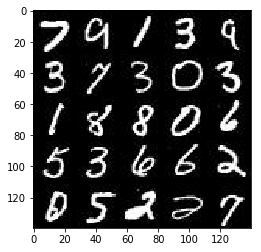

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

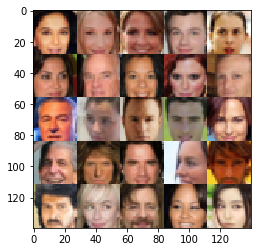

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                        labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                   labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, learning_rate_ = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0

    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                ######## the value of the original dataset ranges from -0.5 to 0.5
                batch_images *= 2.0
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print('Epoch {}/{}...'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 5*5, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 21.6526
Epoch 1/2... Discriminator Loss: 0.0000... Generator Loss: 28.2363
Epoch 1/2... Discriminator Loss: 0.0727... Generator Loss: 5.3786
Epoch 1/2... Discriminator Loss: 0.1079... Generator Loss: 3.8255
Epoch 1/2... Discriminator Loss: 0.0680... Generator Loss: 3.6652
Epoch 1/2... Discriminator Loss: 0.0851... Generator Loss: 11.0623
Epoch 1/2... Discriminator Loss: 2.4105... Generator Loss: 7.4046
Epoch 1/2... Discriminator Loss: 2.3990... Generator Loss: 0.2656
Epoch 1/2... Discriminator Loss: 1.3367... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 0.9734


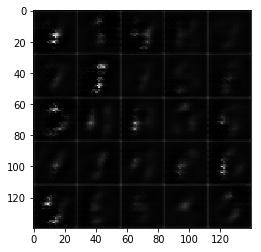

Epoch 1/2... Discriminator Loss: 1.0500... Generator Loss: 1.1169
Epoch 1/2... Discriminator Loss: 1.1314... Generator Loss: 0.7742
Epoch 1/2... Discriminator Loss: 1.1592... Generator Loss: 2.1594
Epoch 1/2... Discriminator Loss: 0.8594... Generator Loss: 1.5023
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.5587
Epoch 1/2... Discriminator Loss: 1.1564... Generator Loss: 2.1927
Epoch 1/2... Discriminator Loss: 0.9164... Generator Loss: 1.2560
Epoch 1/2... Discriminator Loss: 1.0383... Generator Loss: 0.6614
Epoch 1/2... Discriminator Loss: 1.7358... Generator Loss: 0.2878


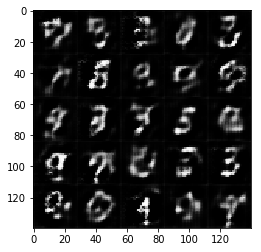

Epoch 1/2... Discriminator Loss: 1.3575... Generator Loss: 0.5055
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 2.3228
Epoch 1/2... Discriminator Loss: 1.3288... Generator Loss: 0.4528
Epoch 1/2... Discriminator Loss: 1.1559... Generator Loss: 0.5368
Epoch 1/2... Discriminator Loss: 0.9827... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 0.8163
Epoch 1/2... Discriminator Loss: 1.0204... Generator Loss: 2.1571
Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.3284
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.0020... Generator Loss: 1.1248


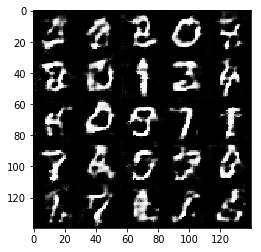

Epoch 1/2... Discriminator Loss: 1.1279... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.5307
Epoch 1/2... Discriminator Loss: 1.0765... Generator Loss: 0.6600
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 0.6913
Epoch 1/2... Discriminator Loss: 1.1734... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 1.1995
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.1071
Epoch 1/2... Discriminator Loss: 1.0397... Generator Loss: 0.7546


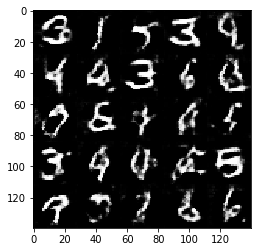

Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 0.6995
Epoch 1/2... Discriminator Loss: 1.0320... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 1.0023... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.4373
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.5785
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 1.6070
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.6973


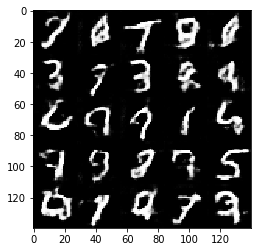

Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.0804... Generator Loss: 0.6908
Epoch 1/2... Discriminator Loss: 1.0896... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.1465... Generator Loss: 0.5228
Epoch 1/2... Discriminator Loss: 0.9629... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 1.8496
Epoch 1/2... Discriminator Loss: 1.0231... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.0456... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.4358
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.1859


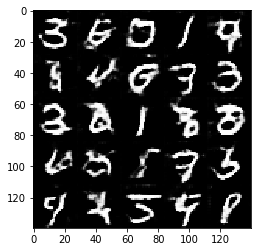

Epoch 1/2... Discriminator Loss: 0.9862... Generator Loss: 1.5520
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 1.2041
Epoch 1/2... Discriminator Loss: 0.9156... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 0.8447... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.2958... Generator Loss: 1.1323
Epoch 1/2... Discriminator Loss: 1.1228... Generator Loss: 0.6162
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 2.9974... Generator Loss: 3.7242
Epoch 1/2... Discriminator Loss: 1.1164... Generator Loss: 0.7899


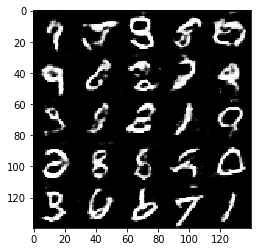

Epoch 1/2... Discriminator Loss: 1.1371... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 0.7518
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.6512
Epoch 1/2... Discriminator Loss: 1.3611... Generator Loss: 2.4985
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 1.1295
Epoch 1/2... Discriminator Loss: 1.0737... Generator Loss: 1.4221
Epoch 1/2... Discriminator Loss: 0.9097... Generator Loss: 1.1368
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 0.9750
Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5275
Epoch 1/2... Discriminator Loss: 1.2440... Generator Loss: 0.4702


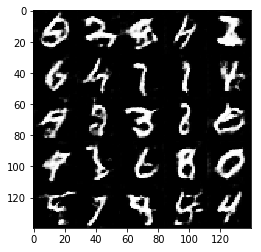

Epoch 1/2... Discriminator Loss: 1.0552... Generator Loss: 1.4832
Epoch 1/2... Discriminator Loss: 0.8851... Generator Loss: 0.9380
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 0.7489
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.6076
Epoch 1/2... Discriminator Loss: 1.0108... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 0.9906... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.3827
Epoch 1/2... Discriminator Loss: 1.0074... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 0.9427... Generator Loss: 1.1524
Epoch 1/2... Discriminator Loss: 0.9937... Generator Loss: 0.9862


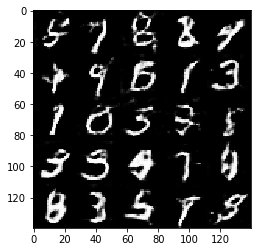

Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.8418
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.6420
Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.5447
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 1.8985
Epoch 2/2... Discriminator Loss: 1.0138... Generator Loss: 0.7504
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.6416
Epoch 2/2... Discriminator Loss: 0.9047... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 0.8173... Generator Loss: 1.1980
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.9322
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 1.0471


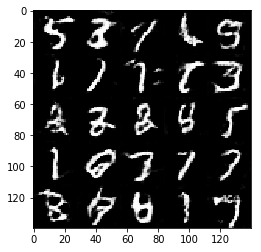

Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 0.8377
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.3378
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.5782
Epoch 2/2... Discriminator Loss: 0.9568... Generator Loss: 1.3662
Epoch 2/2... Discriminator Loss: 1.7781... Generator Loss: 0.2558
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 0.5397
Epoch 2/2... Discriminator Loss: 1.4132... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 0.9812
Epoch 2/2... Discriminator Loss: 1.1682... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 0.9751... Generator Loss: 0.8270


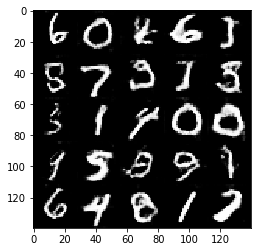

Epoch 2/2... Discriminator Loss: 0.9474... Generator Loss: 0.9398
Epoch 2/2... Discriminator Loss: 1.7804... Generator Loss: 0.2448
Epoch 2/2... Discriminator Loss: 1.1892... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.2285... Generator Loss: 0.6021
Epoch 2/2... Discriminator Loss: 1.4379... Generator Loss: 2.4901
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 0.6356
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 1.1438
Epoch 2/2... Discriminator Loss: 1.6196... Generator Loss: 0.3215
Epoch 2/2... Discriminator Loss: 0.9085... Generator Loss: 0.9985


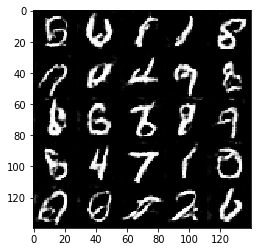

Epoch 2/2... Discriminator Loss: 1.2220... Generator Loss: 0.5200
Epoch 2/2... Discriminator Loss: 0.8517... Generator Loss: 1.0545
Epoch 2/2... Discriminator Loss: 1.0223... Generator Loss: 1.6836
Epoch 2/2... Discriminator Loss: 1.3170... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.7932... Generator Loss: 0.2306
Epoch 2/2... Discriminator Loss: 0.9693... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 1.0340
Epoch 2/2... Discriminator Loss: 1.0554... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.1792... Generator Loss: 0.5989
Epoch 2/2... Discriminator Loss: 0.9209... Generator Loss: 0.8291


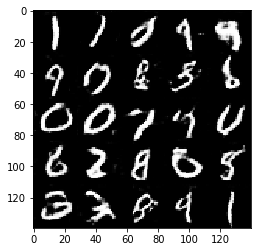

Epoch 2/2... Discriminator Loss: 0.7754... Generator Loss: 1.2979
Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 2.6399
Epoch 2/2... Discriminator Loss: 0.9339... Generator Loss: 1.2994
Epoch 2/2... Discriminator Loss: 1.3692... Generator Loss: 2.3793
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.1364
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 0.7446
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 1.5432
Epoch 2/2... Discriminator Loss: 1.0233... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 0.8321... Generator Loss: 1.3389
Epoch 2/2... Discriminator Loss: 1.2023... Generator Loss: 0.5416


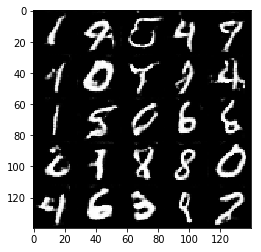

Epoch 2/2... Discriminator Loss: 1.0064... Generator Loss: 0.8566
Epoch 2/2... Discriminator Loss: 0.7264... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 1.9746... Generator Loss: 0.2892
Epoch 2/2... Discriminator Loss: 0.9427... Generator Loss: 1.0496
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.9088
Epoch 2/2... Discriminator Loss: 0.9564... Generator Loss: 0.7825
Epoch 2/2... Discriminator Loss: 0.9866... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 1.2656... Generator Loss: 0.8063
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 0.9075


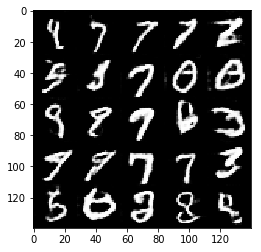

Epoch 2/2... Discriminator Loss: 1.7236... Generator Loss: 0.3163
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 1.0686
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 0.6257
Epoch 2/2... Discriminator Loss: 1.8757... Generator Loss: 0.3212
Epoch 2/2... Discriminator Loss: 0.8685... Generator Loss: 0.9901
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.3833
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 1.2439
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.0107
Epoch 2/2... Discriminator Loss: 1.1809... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 0.7639


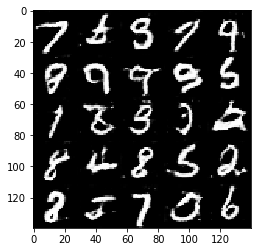

Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 2.0635
Epoch 2/2... Discriminator Loss: 0.9307... Generator Loss: 1.0442
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 0.8792... Generator Loss: 0.8818
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 0.9649... Generator Loss: 0.7803
Epoch 2/2... Discriminator Loss: 2.0394... Generator Loss: 0.2081
Epoch 2/2... Discriminator Loss: 0.6401... Generator Loss: 1.1597
Epoch 2/2... Discriminator Loss: 0.7348... Generator Loss: 1.0895


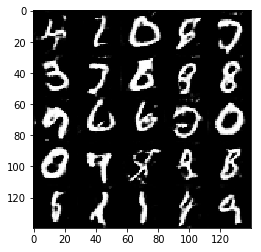

Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.5391
Epoch 2/2... Discriminator Loss: 0.9745... Generator Loss: 1.4802
Epoch 2/2... Discriminator Loss: 1.0456... Generator Loss: 1.8450
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.1127
Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 1.2902
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 2.7980
Epoch 2/2... Discriminator Loss: 0.8333... Generator Loss: 1.5321
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 0.7910
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 2.2397
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.8190


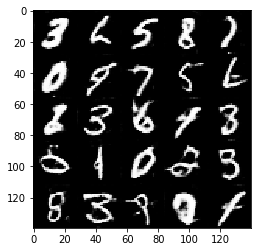

Epoch 2/2... Discriminator Loss: 0.8546... Generator Loss: 1.1913
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.3306
Epoch 2/2... Discriminator Loss: 1.2921... Generator Loss: 0.5747
Epoch 2/2... Discriminator Loss: 1.9185... Generator Loss: 0.2444
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.1392
Epoch 2/2... Discriminator Loss: 1.8632... Generator Loss: 0.2478
Epoch 2/2... Discriminator Loss: 0.7404... Generator Loss: 1.2233


In [12]:
batch_size = 64
z_dim = 64
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 12.6693
Epoch 1/1... Discriminator Loss: 0.2366... Generator Loss: 3.2072
Epoch 1/1... Discriminator Loss: 0.3867... Generator Loss: 11.0474
Epoch 1/1... Discriminator Loss: 3.3071... Generator Loss: 6.9831
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.7264
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 2.0913
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 1.8213
Epoch 1/1... Discriminator Loss: 0.3926... Generator Loss: 1.5545
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 1.6974
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 2.5323


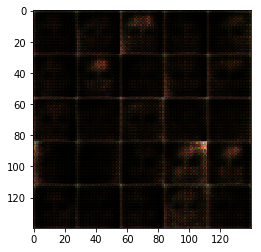

Epoch 1/1... Discriminator Loss: 1.7525... Generator Loss: 5.7848
Epoch 1/1... Discriminator Loss: 2.7710... Generator Loss: 0.0983
Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.4438... Generator Loss: 3.1115
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.6433
Epoch 1/1... Discriminator Loss: 0.7031... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 0.9180... Generator Loss: 0.9740
Epoch 1/1... Discriminator Loss: 0.5412... Generator Loss: 1.0868


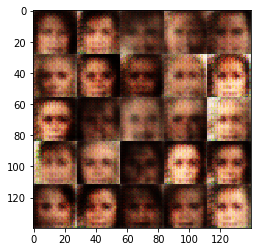

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 3.1184
Epoch 1/1... Discriminator Loss: 1.9282... Generator Loss: 2.5488
Epoch 1/1... Discriminator Loss: 0.9954... Generator Loss: 5.7113
Epoch 1/1... Discriminator Loss: 0.3332... Generator Loss: 1.9096
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.3378... Generator Loss: 2.4645
Epoch 1/1... Discriminator Loss: 0.2881... Generator Loss: 2.5190
Epoch 1/1... Discriminator Loss: 0.2785... Generator Loss: 2.3559
Epoch 1/1... Discriminator Loss: 0.1344... Generator Loss: 3.7397
Epoch 1/1... Discriminator Loss: 0.2759... Generator Loss: 3.1512


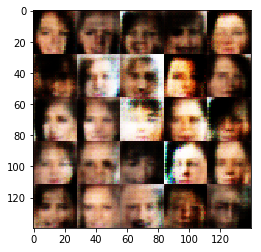

Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 3.5022
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.1277
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 4.1876
Epoch 1/1... Discriminator Loss: 0.5832... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.8543... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 0.1854... Generator Loss: 3.5905
Epoch 1/1... Discriminator Loss: 0.3101... Generator Loss: 4.8505
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 4.3117
Epoch 1/1... Discriminator Loss: 0.1112... Generator Loss: 3.7112
Epoch 1/1... Discriminator Loss: 0.1315... Generator Loss: 4.6510


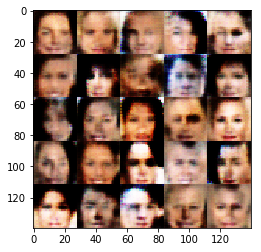

Epoch 1/1... Discriminator Loss: 0.5884... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 0.4402... Generator Loss: 2.8625
Epoch 1/1... Discriminator Loss: 0.1084... Generator Loss: 3.0101
Epoch 1/1... Discriminator Loss: 2.3990... Generator Loss: 0.1540
Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.1849
Epoch 1/1... Discriminator Loss: 0.8992... Generator Loss: 1.0932
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 2.1046
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 1.7260
Epoch 1/1... Discriminator Loss: 0.8863... Generator Loss: 0.9131
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.6044


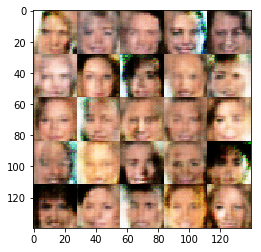

Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.4062
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 3.2132
Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 0.5748... Generator Loss: 1.4241
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.2660
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 1.0599
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 0.8933


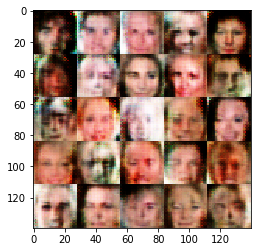

Epoch 1/1... Discriminator Loss: 1.8615... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.0429... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 0.5501... Generator Loss: 2.8700
Epoch 1/1... Discriminator Loss: 0.8735... Generator Loss: 1.2220
Epoch 1/1... Discriminator Loss: 0.4496... Generator Loss: 3.6755
Epoch 1/1... Discriminator Loss: 0.2254... Generator Loss: 2.0397
Epoch 1/1... Discriminator Loss: 0.1591... Generator Loss: 2.6601
Epoch 1/1... Discriminator Loss: 0.2373... Generator Loss: 2.1161
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 1.1196
Epoch 1/1... Discriminator Loss: 0.4930... Generator Loss: 1.2688


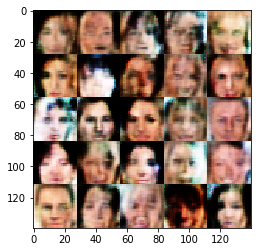

Epoch 1/1... Discriminator Loss: 0.4205... Generator Loss: 3.7549
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 4.0197
Epoch 1/1... Discriminator Loss: 0.4570... Generator Loss: 2.6315
Epoch 1/1... Discriminator Loss: 0.3322... Generator Loss: 3.7642
Epoch 1/1... Discriminator Loss: 0.6178... Generator Loss: 1.0068
Epoch 1/1... Discriminator Loss: 0.2456... Generator Loss: 2.8313
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 1.6261
Epoch 1/1... Discriminator Loss: 0.5620... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 0.2779... Generator Loss: 3.0734
Epoch 1/1... Discriminator Loss: 0.3056... Generator Loss: 3.4652


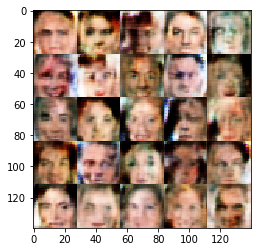

Epoch 1/1... Discriminator Loss: 0.4430... Generator Loss: 1.3676
Epoch 1/1... Discriminator Loss: 1.0229... Generator Loss: 1.3195
Epoch 1/1... Discriminator Loss: 1.1512... Generator Loss: 1.3634
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 0.9976... Generator Loss: 1.2516
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.8744
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 0.9812
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.8633
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.2761
Epoch 1/1... Discriminator Loss: 1.1152... Generator Loss: 0.5973


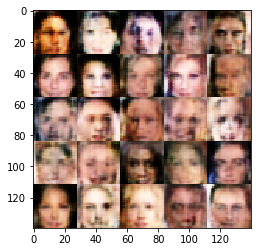

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.1440
Epoch 1/1... Discriminator Loss: 1.0249... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 0.6118... Generator Loss: 0.9985
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 2.1471
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.7305
Epoch 1/1... Discriminator Loss: 0.6010... Generator Loss: 2.7696


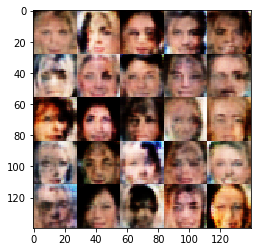

Epoch 1/1... Discriminator Loss: 0.5928... Generator Loss: 2.2298
Epoch 1/1... Discriminator Loss: 0.2788... Generator Loss: 2.0891
Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 3.3567
Epoch 1/1... Discriminator Loss: 0.2924... Generator Loss: 1.7755
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.6327... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 0.9388... Generator Loss: 2.4080
Epoch 1/1... Discriminator Loss: 0.2708... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 1.4636


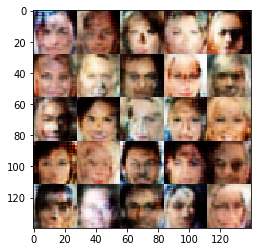

Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 0.8334... Generator Loss: 1.7603
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.2480
Epoch 1/1... Discriminator Loss: 0.7587... Generator Loss: 1.8844
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.7763
Epoch 1/1... Discriminator Loss: 2.1210... Generator Loss: 2.4849
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 3.4085
Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 0.9490


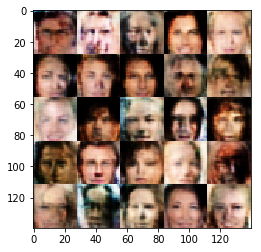

Epoch 1/1... Discriminator Loss: 0.3738... Generator Loss: 4.3130
Epoch 1/1... Discriminator Loss: 0.3991... Generator Loss: 1.5522
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 2.8155
Epoch 1/1... Discriminator Loss: 1.1967... Generator Loss: 3.3745
Epoch 1/1... Discriminator Loss: 0.3522... Generator Loss: 2.1600
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.3835
Epoch 1/1... Discriminator Loss: 0.5193... Generator Loss: 1.1241
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 0.1367... Generator Loss: 3.7208


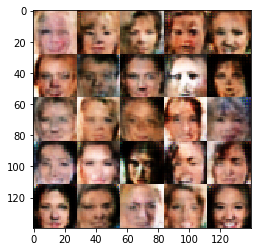

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.1104... Generator Loss: 0.6078
Epoch 1/1... Discriminator Loss: 0.5079... Generator Loss: 1.1827
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 1.4407
Epoch 1/1... Discriminator Loss: 1.2581... Generator Loss: 1.0252
Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 2.4268
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 1.9981
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.8229


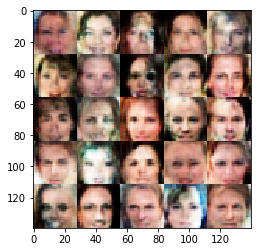

Epoch 1/1... Discriminator Loss: 1.1175... Generator Loss: 2.7925
Epoch 1/1... Discriminator Loss: 0.9527... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 0.8054... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.3847
Epoch 1/1... Discriminator Loss: 0.5810... Generator Loss: 1.1571
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.4147
Epoch 1/1... Discriminator Loss: 0.8186... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.4782


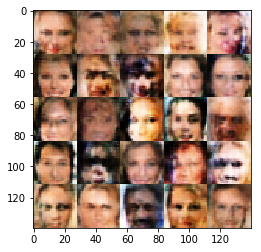

Epoch 1/1... Discriminator Loss: 0.4530... Generator Loss: 1.9300
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 2.4680
Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 2.1201
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.0680
Epoch 1/1... Discriminator Loss: 0.8199... Generator Loss: 3.9940
Epoch 1/1... Discriminator Loss: 1.1158... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 0.6571... Generator Loss: 1.6823
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 1.3485
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.3321


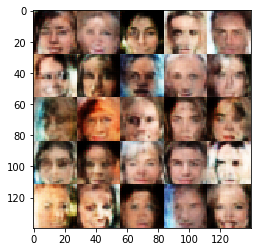

Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 0.5774
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 2.4784
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.9796... Generator Loss: 0.2162
Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 2.3456
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 2.9034
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 2.4369


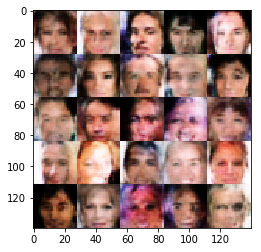

Epoch 1/1... Discriminator Loss: 0.7036... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 0.4293... Generator Loss: 3.6329
Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.3499
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 1.2859
Epoch 1/1... Discriminator Loss: 0.5303... Generator Loss: 1.7431
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.6117
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.4824
Epoch 1/1... Discriminator Loss: 2.5837... Generator Loss: 0.1171
Epoch 1/1... Discriminator Loss: 0.5203... Generator Loss: 1.8318


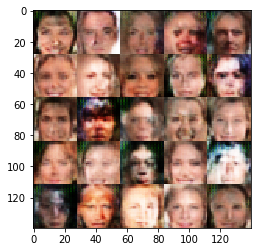

Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 0.8184
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.1367
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 2.2891
Epoch 1/1... Discriminator Loss: 0.4456... Generator Loss: 2.2070
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.4076
Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 1.6140... Generator Loss: 0.3199
Epoch 1/1... Discriminator Loss: 0.7084... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 0.6129


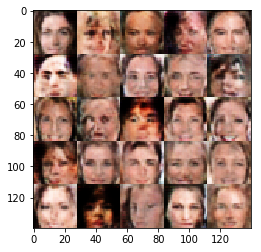

Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.7772
Epoch 1/1... Discriminator Loss: 1.6174... Generator Loss: 0.2804
Epoch 1/1... Discriminator Loss: 0.8024... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 2.4492
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.6181
Epoch 1/1... Discriminator Loss: 0.6821... Generator Loss: 1.1368
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 2.9942
Epoch 1/1... Discriminator Loss: 0.3428... Generator Loss: 3.0998
Epoch 1/1... Discriminator Loss: 0.5880... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 1.0707... Generator Loss: 0.5585


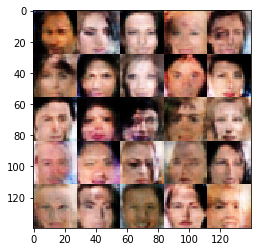

Epoch 1/1... Discriminator Loss: 0.8165... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.7732... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 0.5853... Generator Loss: 1.7060
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.5393
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 1.4043
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.3487
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 0.8397... Generator Loss: 1.0907


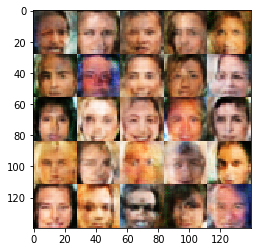

Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 0.9298
Epoch 1/1... Discriminator Loss: 0.7607... Generator Loss: 1.4425
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.3208
Epoch 1/1... Discriminator Loss: 0.7310... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.1768... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 2.1079
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 2.1502
Epoch 1/1... Discriminator Loss: 0.8360... Generator Loss: 0.8952


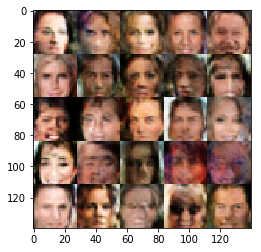

Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 1.2753
Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.8492
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.4368
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.1389
Epoch 1/1... Discriminator Loss: 0.5179... Generator Loss: 2.9677
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 0.9894
Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 0.6559


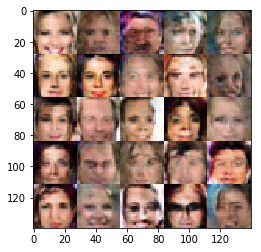

Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 3.0111
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 1.3803
Epoch 1/1... Discriminator Loss: 0.8314... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.0574
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.6847
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 3.4998
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 0.3944... Generator Loss: 1.7342
Epoch 1/1... Discriminator Loss: 0.5024... Generator Loss: 1.9403


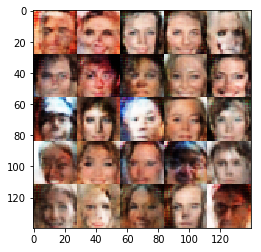

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 2.8486
Epoch 1/1... Discriminator Loss: 0.5910... Generator Loss: 1.7461
Epoch 1/1... Discriminator Loss: 0.1822... Generator Loss: 2.6021
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 2.2508
Epoch 1/1... Discriminator Loss: 0.3683... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.8186... Generator Loss: 0.2741
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.4149


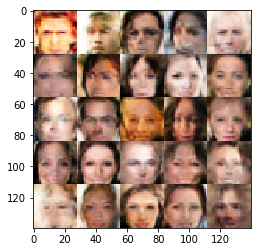

Epoch 1/1... Discriminator Loss: 0.6611... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 1.4717
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 1.7844
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 2.3964
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 0.5616... Generator Loss: 1.5056


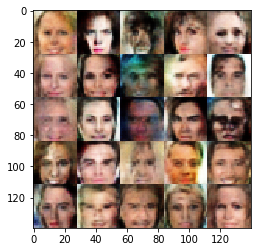

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.7037... Generator Loss: 0.2755
Epoch 1/1... Discriminator Loss: 1.8077... Generator Loss: 0.2595
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 2.8418
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 0.9867
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.8640... Generator Loss: 2.7990
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.6332
Epoch 1/1... Discriminator Loss: 0.7861... Generator Loss: 1.5412


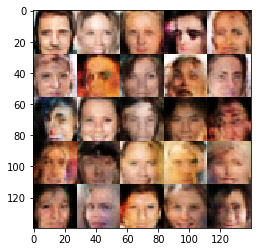

Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 1.9454
Epoch 1/1... Discriminator Loss: 0.6675... Generator Loss: 1.5087
Epoch 1/1... Discriminator Loss: 0.5507... Generator Loss: 1.3098
Epoch 1/1... Discriminator Loss: 0.6325... Generator Loss: 1.0061
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.1303... Generator Loss: 3.9779
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.4259
Epoch 1/1... Discriminator Loss: 0.2627... Generator Loss: 2.9268
Epoch 1/1... Discriminator Loss: 2.3524... Generator Loss: 4.5066
Epoch 1/1... Discriminator Loss: 0.6766... Generator Loss: 2.0553


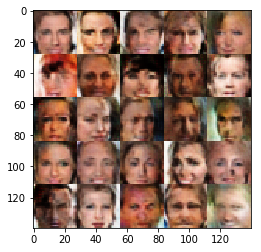

Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 0.7091... Generator Loss: 1.7569
Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.4350
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 0.7333... Generator Loss: 0.9373
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.7927
Epoch 1/1... Discriminator Loss: 0.8061... Generator Loss: 0.7734


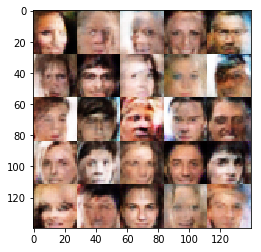

Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 0.9529
Epoch 1/1... Discriminator Loss: 0.6340... Generator Loss: 1.5984
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.1503
Epoch 1/1... Discriminator Loss: 0.5936... Generator Loss: 1.1692
Epoch 1/1... Discriminator Loss: 2.1649... Generator Loss: 0.1879
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.5546
Epoch 1/1... Discriminator Loss: 0.6220... Generator Loss: 1.2283
Epoch 1/1... Discriminator Loss: 0.5738... Generator Loss: 2.2047
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 0.6904... Generator Loss: 1.0451


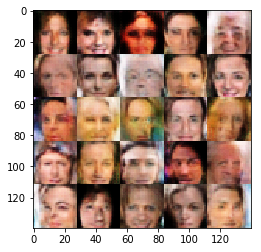

Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.3118
Epoch 1/1... Discriminator Loss: 0.5618... Generator Loss: 1.3417
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 2.0656
Epoch 1/1... Discriminator Loss: 1.9368... Generator Loss: 0.2404
Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.1799
Epoch 1/1... Discriminator Loss: 0.4823... Generator Loss: 1.7894
Epoch 1/1... Discriminator Loss: 0.2157... Generator Loss: 2.2179
Epoch 1/1... Discriminator Loss: 0.6676... Generator Loss: 1.0677


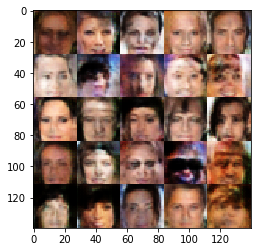

Epoch 1/1... Discriminator Loss: 0.9620... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 0.6083... Generator Loss: 2.4986
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 2.2942... Generator Loss: 0.1478
Epoch 1/1... Discriminator Loss: 0.4817... Generator Loss: 2.4811
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.1889


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.